In [1]:
import matplotlib.pyplot as plt
import urllib.request, json
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Embedding, Dense, SimpleRNN
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import word_tokenize

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

2024-09-15 21:39:51.454752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 21:39:51.473384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 21:39:51.473415: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 21:39:51.485104: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-15 21:39:52.143764: W tensorflow/compiler/tf

Num GPUs Available:  1


2024-09-15 21:39:52.896035: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-15 21:39:52.934526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-15 21:39:52.937231: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
plt.rcParams['figure.figsize'] = (5, 5)
plt.rc('font', size=5)

In [3]:
res = urllib.request.urlopen("http://127.0.0.1:8000/api/vagas?treinamento=true")
data = json.loads(res.read())
exemplos_treinamento = data['data']
qtd_pos = data['qtd_pos']
qtd_neg = data['qtd_neg']

In [4]:
sentences = []
pos = []
maxlen = 46

for exemplo in exemplos_treinamento:
    tokens = list(map(lambda x: str(x).lower(), word_tokenize(exemplo['txtVaga'])))
    aplicacao = exemplo['isApplied']
    sentences.append(tokens)
    pos.append([int(bool(aplicacao))])
    
    if len(tokens) > maxlen:
        maxlen = len(tokens)
        print("Maxlen atualizado: ",  maxlen)

In [5]:
word_list = ['<pad>'] + sorted(set(sum(sentences, []))) + ['_UNKNOWN']
word2idx = {word:idx for idx, word in enumerate(word_list)}
idx2word = {idx:word for idx, word in enumerate(word_list)}
pos_list = sorted(set(sum(pos, [])))
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}
X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], sentences))
y = list(map(lambda sentence: [pos2idx.get(token) for token in sentence], pos))
X = pad_sequences(X, maxlen=maxlen, padding='post')
X_mask = (X != 0).astype(np.float32)
X_len = np.array(list((map(lambda sentence: len(sentence), sentences))), dtype=np.float32)
y = pad_sequences(y, maxlen=1, padding='post')

json_str = json.dumps(word2idx, ensure_ascii=False)
json_str = json.loads(json_str)
with open('char2idx.json', 'w', encoding='utf-8') as json_file:
    json.dump(json_str, json_file, ensure_ascii=False)

Epoch 1/10


2024-09-15 21:40:31.069972: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-15 21:40:31.074204: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-15 21:40:31.077367: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9742 - auc: 0.6268 - fn: 1.5000 - fp: 184.0000 - loss: 0.3848 - prc: 0.0420 - precision: 0.0285 - recall: 0.7889

I0000 00:00:1726447235.859958   80354 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.9127 - auc: 0.5807 - fn: 65.6364 - fp: 1181.5454 - loss: 0.4699 - prc: 0.0427 - precision: 0.0367 - recall: 0.3944
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9107 - auc: 0.7115 - fn: 42.6061 - fp: 1640.3334 - loss: 0.3961 - prc: 0.0917 - precision: 0.0358 - recall: 0.5911
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8725 - auc: 0.7551 - fn: 32.5758 - fp: 1894.1818 - loss: 0.4022 - prc: 0.1665 - precision: 0.0432 - recall: 0.7386
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9479 - auc: 0.7676 - fn: 34.3333 - fp: 1488.2727 - loss: 0.3636 - prc: 0.1651 - precision: 0.0413 - recall: 0.6576
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9047 - auc: 0.8237 - fn: 29.8182 - fp: 1479.1818 - loss: 0.3639 - prc: 0.2269 - precision: 0.0503 - recall: 0.7591
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9014 - auc: 0.8269 - fn: 26.9091 - fp: 1448.0

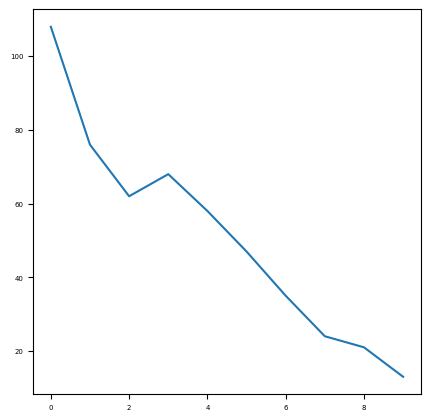

In [6]:

num_classes = len(pos2idx)
input_dim = len(word2idx)
output_dim = len(word2idx)
exemples_dim = len(sentences)
batch_size = 300
epochs = 10

optimizer = Adam()

loss_function = BinaryCrossentropy()
additional_metrics = [
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.6),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

model = Sequential()
model.add(Embedding(
    input_dim=input_dim,
    output_dim=output_dim,
    mask_zero=True,
    embeddings_initializer=tf.keras.initializers.random_normal
))
model.add(SimpleRNN(units=3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
#model.summary()

weight_for_0 = (1 / qtd_neg) * (exemples_dim / 3.0)
weight_for_1 = (1 / qtd_pos) * (exemples_dim / 3.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

history = model.fit(X, y, class_weight=class_weight, batch_size=batch_size, shuffle=True, epochs=epochs, verbose=True)

plt.figure()
plt.plot(history.history['fn'])
plt.show()

In [ ]:
# Exemplo de inferência
novo_X = [['desenvolvedor', 'web', 'java','junior']]
novo_X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], novo_X))
novo_X = pad_sequences(novo_X, maxlen=maxlen, padding='post')
y_pred = model.predict(novo_X, batch_size=1)[0]
y_pred

In [ ]:
model.save("model.keras")